In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import optuna
from optuna.trial import TrialState

In [31]:
X1 = pd.read_csv("preprocessed_datasets/bank_data.csv")
y1 = pd.read_csv("preprocessed_datasets/bank_target.csv")
X1_full = X1.copy()
X1_full["target"] = y1
X1_25 = X1_full.sample(frac=0.25, random_state=42)
X1_50 = X1_full.sample(frac=0.50, random_state=42)
X1_75 = X1_full.sample(frac=0.75, random_state=42)
X1_100 = X1_full.copy() 

In [32]:
def split_data(df):
    X = df.drop(columns=["target"])
    y = df["target"]
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [33]:
X1_25train, X1_25test, y1_25train, y1_25test = split_data(X1_25)
X1_50train, X1_50test, y1_50train, y1_50test = split_data(X1_50)
X1_75train, X1_75test, y1_75train, y1_75test = split_data(X1_75)
X1_100train, X1_100test, y1_100train, y1_100test = split_data(X1_100)

In [34]:
def chart_random(stabilized_at, brier_per_iter, iters, best_so_far, dataset_name):
    plt.figure(figsize=(10, 5))
    plt.scatter(iters, brier_per_iter, s=12, alpha=0.6, label='Brier per iteration')
    plt.plot(iters, best_so_far, linewidth=2, label='Best so far')
    if stabilized_at is not None:
        plt.axvline(stabilized_at, linestyle='--', linewidth=1, label=f'Stabilized at {stabilized_at}')
    plt.xlabel('Iteration')
    plt.ylabel('Brier score (lower is better)')
    plt.title(f'Brier per Random Search iteration and best-so-far for {dataset_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [35]:
WINDOW_SIZE = 10           
ABS_TOL = 0.001 
def detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL, window_len=WINDOW_SIZE):
    """
    Szuka pierwszego okna długości window_len takie, że wszystkie window_len-1 kolejnych różnic
    między elementami okna mają wartość absolutną < abs_tol.
    Zwraca (stabilized_at_1based, stabilized_value) lub (None, None).
    """
    arr = np.asarray(best_so_far)
    n = arr.shape[0]
    if n < window_len:
        return None, None

    for start in range(0, n - window_len + 1):
        window = arr[start:start + window_len]
        diffs = np.abs(np.diff(window))
        if np.all(diffs < abs_tol):
            return start + 1, float(window[0])
    return None, None

In [36]:
from sklearn.model_selection import StratifiedKFold
N_ITER = 100
CV=5
RANDOM_STATE=42

def bayes_optimize(X_loc, y_arr, n_trials=N_ITER, cv=CV, random_state=RANDOM_STATE, n_jobs_model=1, pruner_n_startup_trials=10):
    y_arr = y_arr.to_numpy().ravel()
    cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    sampler = optuna.samplers.TPESampler(seed=random_state)
    pruner = optuna.pruners.MedianPruner(n_startup_trials=pruner_n_startup_trials, n_warmup_steps=0, interval_steps=1)
    study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)

    def objective(trial):
        params = {
    'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
    'gamma': trial.suggest_float('gamma', 1e-4, 1e1, log=True)
}

        model = make_pipeline(
        StandardScaler(),
        SVC(kernel='rbf', probability=True, random_state=42, **params)
    )

        neg_briers = []

        for fold_idx, (train_idx, val_idx) in enumerate(cv_splitter.split(X_loc, y_arr)):
            X_tr = X_loc.iloc[train_idx] 
            X_val = X_loc.iloc[val_idx]
            y_tr = y_arr[train_idx]
            y_val = y_arr[val_idx]

            model.fit(
                X_tr, y_tr
            )

            probs = model.predict_proba(X_val)[:, 1]
            neg_brier = -brier_score_loss(y_val, probs) 
            neg_briers.append(neg_brier)

            mean_neg_so_far = float(np.mean(neg_briers))
            trial.report(mean_neg_so_far, step=fold_idx)
            if trial.should_prune():
                raise optuna.TrialPruned()
            
        mean_neg = float(np.mean(neg_briers))
        return mean_neg
    
    study.optimize(objective, n_trials=n_trials)

    trials = study.trials
    neg_scores = [t.value if t.value is not None else np.nan for t in trials]
    brier_per_iter = -np.array(neg_scores, dtype=float)

    best_so_far = []
    current_best = np.inf
    for v in brier_per_iter:
        if np.isnan(v):
            best_so_far.append(current_best if current_best != np.inf else np.nan)
        else:
            if v < current_best:
                current_best = v
            best_so_far.append(current_best)
    best_so_far = np.array(best_so_far, dtype=float)

    completed = [t for t in trials if t.state == TrialState.COMPLETE and t.value is not None]
    best_trial = max(completed, key=lambda tr: tr.value)
    best_params = best_trial.params
    best_brier = float(best_trial.value)

    return {
        'brier_per_iter': brier_per_iter,
        'best_so_far': best_so_far,
        'best_params': best_params,
        'best_brier': best_brier
    }

In [37]:
result_all = bayes_optimize(X1_100train, y1_100train)

[I 2025-10-21 15:25:42,465] A new study created in memory with name: no-name-ab155721-00cd-4acc-9fa5-cc7260b3bf57
[I 2025-10-21 15:26:51,290] Trial 0 finished with value: -0.24438925173552759 and parameters: {'C': 0.1767016940294795, 'gamma': 5.669849511478847}. Best is trial 0 with value: -0.24438925173552759.
[I 2025-10-21 15:28:04,100] Trial 1 finished with value: -0.2197920324828427 and parameters: {'C': 24.658329458549105, 'gamma': 0.09846738873614563}. Best is trial 1 with value: -0.2197920324828427.
[I 2025-10-21 15:29:03,456] Trial 2 finished with value: -0.20810418713906048 and parameters: {'C': 0.008632008168602538, 'gamma': 0.000602521573620386}. Best is trial 2 with value: -0.20810418713906048.
[I 2025-10-21 15:30:01,738] Trial 3 finished with value: -0.24063937776836042 and parameters: {'C': 0.002231010801867922, 'gamma': 2.1423021757741068}. Best is trial 2 with value: -0.20810418713906048.
[I 2025-10-21 15:31:13,164] Trial 4 finished with value: -0.22858496295978706 and 

In [38]:
brier_per_iter = result_all["brier_per_iter"]
print(len(brier_per_iter))
best_so_far = result_all["best_so_far"]
result_all["best_params"]

100


{'C': 4.177031028761628, 'gamma': 0.010251858324347664}

In [39]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)


In [40]:
print(stabilized_at, stabilized_value)


7 0.1898212387838196


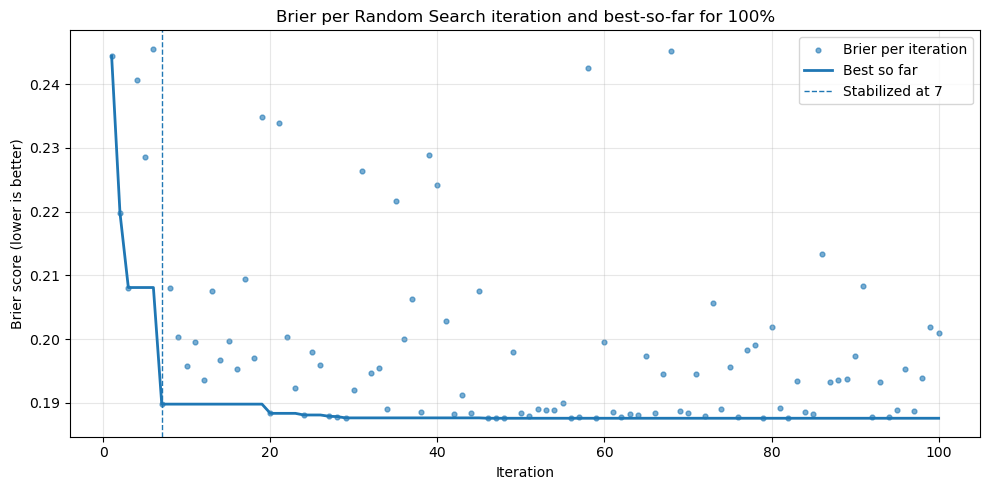

In [41]:
iters = np.arange(1, 101)
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, dataset_name="100%")


In [42]:
result_25 = bayes_optimize(X1_25train, y1_25train)


[I 2025-10-21 16:30:21,976] A new study created in memory with name: no-name-157d25a3-ffce-407c-acde-189c9d7f7ad4
[I 2025-10-21 16:30:27,383] Trial 0 finished with value: -0.2485684345398947 and parameters: {'C': 0.1767016940294795, 'gamma': 5.669849511478847}. Best is trial 0 with value: -0.2485684345398947.
[I 2025-10-21 16:30:32,682] Trial 1 finished with value: -0.23817721498065433 and parameters: {'C': 24.658329458549105, 'gamma': 0.09846738873614563}. Best is trial 1 with value: -0.23817721498065433.
[I 2025-10-21 16:30:37,297] Trial 2 finished with value: -0.20507198886061215 and parameters: {'C': 0.008632008168602538, 'gamma': 0.000602521573620386}. Best is trial 2 with value: -0.20507198886061215.
[I 2025-10-21 16:30:41,408] Trial 3 finished with value: -0.24786831619879682 and parameters: {'C': 0.002231010801867922, 'gamma': 2.1423021757741068}. Best is trial 2 with value: -0.20507198886061215.
[I 2025-10-21 16:30:45,355] Trial 4 finished with value: -0.24275429139472063 and 

In [43]:
brier_per_iter = result_25["brier_per_iter"]
print(len(brier_per_iter))
best_so_far = result_25["best_so_far"]
result_25["best_params"]

100


{'C': 2.720733940437542, 'gamma': 0.0038932314792304375}

In [44]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)


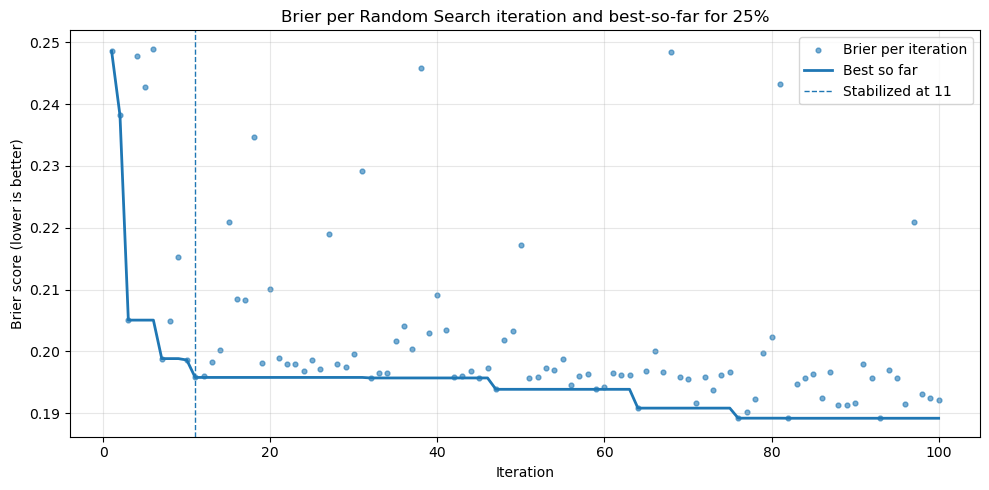

In [45]:
iters = np.arange(1, 101)
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, dataset_name="25%")


In [46]:
print(stabilized_at, stabilized_value)


11 0.19580214882520858


In [47]:
result_50 = bayes_optimize(X1_50train, y1_50train)


[I 2025-10-21 16:33:44,957] A new study created in memory with name: no-name-f6c19cbd-f90b-4d53-82a0-2bde0c7803f0
[I 2025-10-21 16:34:01,539] Trial 0 finished with value: -0.24689734500782495 and parameters: {'C': 0.1767016940294795, 'gamma': 5.669849511478847}. Best is trial 0 with value: -0.24689734500782495.
[I 2025-10-21 16:34:18,673] Trial 1 finished with value: -0.2293708294094674 and parameters: {'C': 24.658329458549105, 'gamma': 0.09846738873614563}. Best is trial 1 with value: -0.2293708294094674.
[I 2025-10-21 16:34:33,648] Trial 2 finished with value: -0.21011088554703677 and parameters: {'C': 0.008632008168602538, 'gamma': 0.000602521573620386}. Best is trial 2 with value: -0.21011088554703677.
[I 2025-10-21 16:34:48,216] Trial 3 finished with value: -0.24531826381371427 and parameters: {'C': 0.002231010801867922, 'gamma': 2.1423021757741068}. Best is trial 2 with value: -0.21011088554703677.
[I 2025-10-21 16:35:04,858] Trial 4 finished with value: -0.2354341129401146 and p

In [48]:
brier_per_iter = result_50["brier_per_iter"]
print(len(brier_per_iter))
best_so_far = result_50["best_so_far"]
result_50["best_params"]

100


{'C': 1.629812062881743, 'gamma': 0.005950453701289126}

In [49]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)

In [50]:
print(stabilized_at, stabilized_value)

13 0.19344068478492868


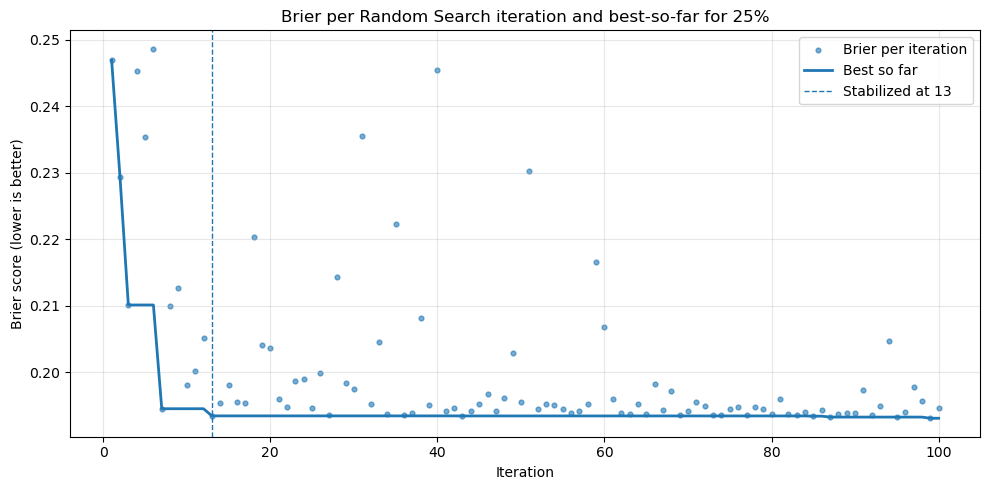

In [51]:
iters = np.arange(1, 101)
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, dataset_name="25%")

In [52]:
result_75 = bayes_optimize(X1_75train, y1_75train)


[I 2025-10-21 16:48:28,898] A new study created in memory with name: no-name-7f7ab0ca-28cb-4f6e-967a-801543282d3a
[I 2025-10-21 16:49:08,460] Trial 0 finished with value: -0.24600759819205997 and parameters: {'C': 0.1767016940294795, 'gamma': 5.669849511478847}. Best is trial 0 with value: -0.24600759819205997.
[I 2025-10-21 16:49:49,117] Trial 1 finished with value: -0.22478401950294594 and parameters: {'C': 24.658329458549105, 'gamma': 0.09846738873614563}. Best is trial 1 with value: -0.22478401950294594.
[I 2025-10-21 16:50:23,593] Trial 2 finished with value: -0.2096040398931993 and parameters: {'C': 0.008632008168602538, 'gamma': 0.000602521573620386}. Best is trial 2 with value: -0.2096040398931993.
[I 2025-10-21 16:50:57,339] Trial 3 finished with value: -0.24183078938450847 and parameters: {'C': 0.002231010801867922, 'gamma': 2.1423021757741068}. Best is trial 2 with value: -0.2096040398931993.
[I 2025-10-21 16:51:35,493] Trial 4 finished with value: -0.2325990794772593 and pa

In [53]:
brier_per_iter = result_75["brier_per_iter"]
print(len(brier_per_iter))
best_so_far = result_75["best_so_far"]
result_75["best_params"]

100


{'C': 3.775008893432737, 'gamma': 0.011281404568596604}

In [54]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)


In [55]:
print(stabilized_at, stabilized_value)


7 0.19149908881225514


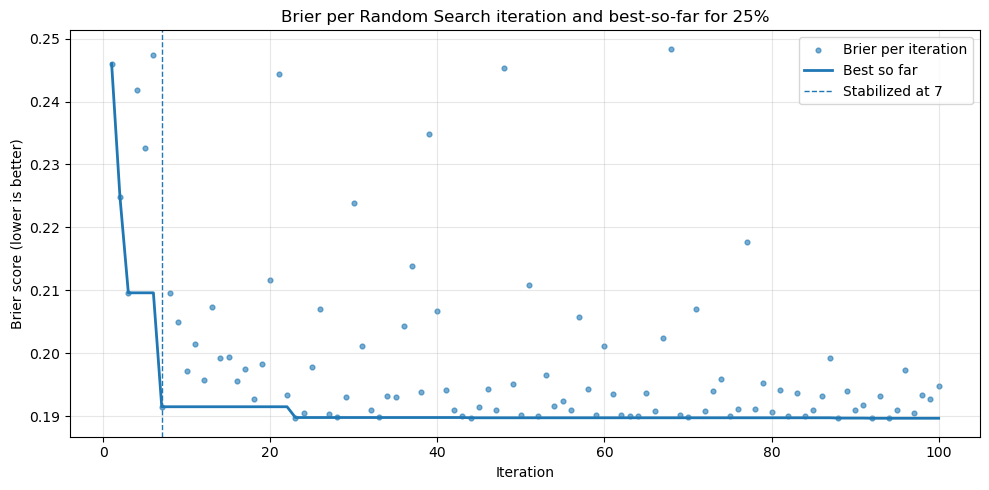

In [56]:
iters = np.arange(1, 101)
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, dataset_name="25%")

In [5]:
data = {"model": ["SVM", "SVM","SVM","SVM"],
         "frac" : [1,0.75,0.5,0.25],
        "params" : [result_all["best_params"], result_75["best_params"], result_50["best_params"], result_25["best_params"]],
        "brier": [result_all["best_so_far"],result_75["best_so_far"],result_50["best_so_far"],result_25["best_so_far"]]}
df = pd.DataFrame(data)
df

NameError: name 'result_all' is not defined

In [10]:
data = {"model": ["SVM", "SVM","SVM","SVM"],
         "frac" : [1,0.75,0.5,0.25],
        "params" : [{'C': 4.177031028761628, 'gamma': 0.010251858324347664}, {'C': 3.775008893432737, 'gamma': 0.011281404568596604}, {'C': 1.629812062881743, 'gamma': 0.005950453701289126}, {'C': 2.720733940437542, 'gamma': 0.0038932314792304375}],
        "brier": [0.1876086998390129,0.1896724618482984,0.1934321925950191,0.1956284739244753]}
df = pd.DataFrame(data)
df

,model,frac,params,brier
0,SVM,1.00,"{'C': 4.177031028761628, 'gamma': 0.0102518583...",0.187609
1,SVM,0.75,"{'C': 3.775008893432737, 'gamma': 0.0112814045...",0.189672
2,SVM,0.50,"{'C': 1.629812062881743, 'gamma': 0.0059504537...",0.193432
3,SVM,0.25,"{'C': 2.720733940437542, 'gamma': 0.0038932314...",0.195628
